Для начала подготовим среду для анализа данных

In [4]:
#Подключаем хранилище с данными
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
#Выбираем GPU как устройтво
device = torch.device("cuda")# if torch.cuda.is_available() else "cpu")


In [6]:
#Загружаем данные
import json

with open('/content/drive/MyDrive/CupIT/ranking_train.jsonl', 'r') as json_file:
    json_list = list(json_file)
listOfPostsAsDicts = [json.loads(json_str) for json_str in json_list]
justcomments = [post["comments"] for post in listOfPostsAsDicts]
justcomments = [comment for comments in justcomments for comment in comments]
print(len(justcomments))


440535


In [7]:
#Собираем данные в таблицу
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(justcomments)
posts = [[post["text"]]*5 for post in listOfPostsAsDicts]
posts = [subpost for post in posts for subpost in post]
df["post"] = posts
cols = ["post","text","score"]
df = df[cols]
df.columns = ["post","comment","score"]


Посмотрим по 3 комментария каждого рейтинга

In [ ]:
for i in range(5):
  for j in range(3):
    print(f"Rating {i}:",listOfPostsAsDicts[j]["comments"][i]["text"])
  print()


Rating 5: Going back to school is not identical with giving up. Some founders go back to school and keep working on the startup while there.  However, those do so much worse than the people who work on the startup full-time that going back to school seems, in practice, not too far removed from a death sentence for a startup.Off the top of my head, I'd guess we've had about 8 startups where the founders went back to school.  It doesn't only happen with summer batches.  Founders from winter batches do it too.Usually the reason is that the startup isn't doing very well. However, that judgement depends a lot on how determined the founders are.  One reason we now shy away from funding people still in school is that they often unconsciously want the startup to fail, because the idea of dropping out frightens them.A lot of startups look bad after 3 months.  Someone who's out of school and has to make it work or get a job in a cubicle will say "don't worry, we'll figure out how to make it succ

Построим гистограммы для длин текстов, слов, и количества слов относительно рейтинга комментариев

<BarContainer object of 5 artists>

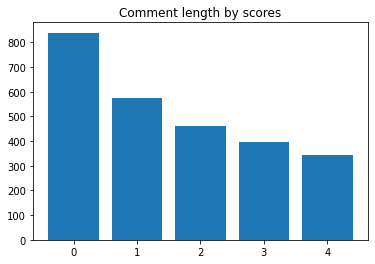

In [ ]:
#Построим гистограмму зависимости длины комментария от его рейтинга
lens = {0:0,1:0,2:0,3:0,4:0}

for comment, score in zip(df["comment"],df["score"]):
  lens[score] += len(comment)

for key,value in lens.items():
  lens[key] = value/(len(df)/5)

plt.figure(3)
plt.title('Comment length by scores')
plt.bar(lens.keys(), lens.values())

#По гистограмме видно, что более длинные комментарии в среднем получают более высокую оценку

По гистограмме видно, что более длинные комментарии в среднем получают более высокую оценку. Это может быть связано с тем, что в более длинных комментариях обычно больше информации, что позволяет автору высказать более подробные и обоснованные мнения. Кроме того, более длинные комментарии могут привлекать больше внимания других пользователей, что может привести к более высокой оценке. Однако это не означает, что короткие комментарии всегда получают низкие оценки.

<BarContainer object of 5 artists>

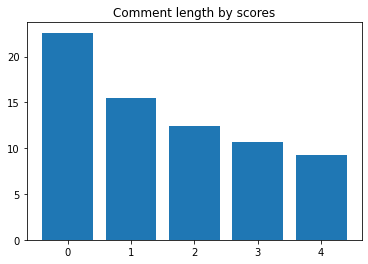

In [ ]:
#Построим гистограмму зависимости отношения длины комментария к длине поста от его рейтинга
lens1 = {i: 0 for i in range(5)}
for comment, score, post in zip(df["comment"],df["score"],df["post"]):
  lens1[score] += len(comment)/len(post)

for key,value in lens1.items():
  lens1[key] = value/(len(df)/5)

plt.figure(3)
plt.title('Comment length by scores')
plt.bar(lens1.keys(), lens1.values())
#График почти идентичен предыдущему, из чего можно сделать вывод что между отношением длин поста и комментария и рейтингом комментария нет явной зависимости

График почти идентичен предыдущему, из чего можно сделать вывод что между отношением длин поста и комментария и рейтингом комментария нет явной зависимости.

<Axes: >

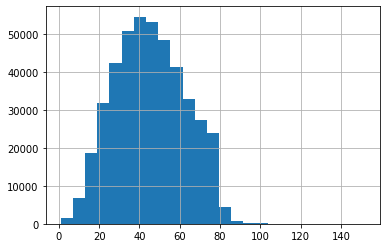

In [ ]:
#Распределение количество символов в тексте поста
df["post"].str.len().hist(bins=25)
#Из графика видно, что большая часть постов содержит от 20 до 60 символов. Возможно, если бы дисперсия была побольше, можно было бы найти связь между длиной поста,комментария и рейтингом.

Из графика видно, что большая часть постов содержит от 20 до 60 символов. Возможно, если бы дисперсия была побольше, можно было бы найти связь между длиной поста,комментария и рейтингом.

<Axes: >

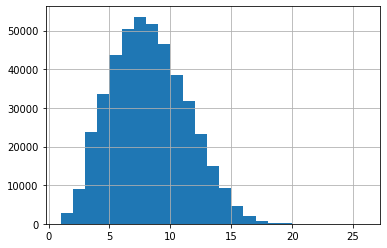

In [ ]:
#Количество слов в тексте поста
df["post"].str.split().map(lambda x: len(x)).hist(bins=25)
#В среднем посты в наборе данных достаточно короткие, 5-10 слов, график аналогичен предыдущему.

В среднем посты в наборе данных достаточно короткие, 5-10 слов, график аналогичен предыдущему.


<Axes: >

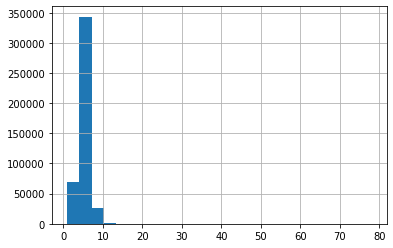

In [ ]:
#Средняя длина слов в посте
import numpy as np
df['post'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(bins = 25)
#Как можно видеть, из-за выбросов в данных автоматический масшатб графика не очень информативен.

Как можно видеть, из-за выбросов в данных автоматический масшатб графика не очень информативен. В тексте некоторых постов присутствуют очень длинные слова.


<Axes: >

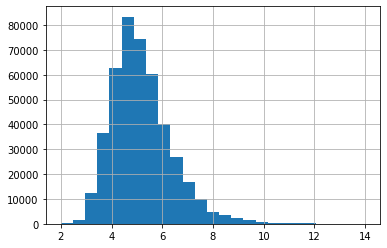

In [ ]:
#Средняя длина слов в посте (диапазон от 2 до 14)
df['post'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(range=(2,14), bins = 25)
#Средняя длина слова примерно равна 5.5 символам, что соответствует стандартному распределению для английского языка. 

Средняя длина слова примерно равна 5.5 символам, что соответствует стандартному распределению для английского языка.


In [ ]:
#Посмотрим какие слова больше 20 символов повлияли на гарфик
for i in range(0,len(df["post"]),4):
  for word in df["post"][i].split():
    if len(word) > 20:
      print(f"Word:{word}")
#Это преимущественно ссылки, либо несколько слов, написаных через разделитель не являющийся пробелом.

Word:&#8235;&#8236;&#8237;&#8238;&#8234;&#8235;&#8236;&#8237;&#8238;&#1161;(epiws
Word:&#8235;&#8236;&#8237;&#8238;&#8234;&#8235;&#8236;&#8237;&#8238;&#1161;(epiws
Word:entrepreneurial/business
Word:Rails/Django/PHP/etc.
Word:Left-brain/right-brain
Word:slashdotted/reddited/yc.newsed
Word:slashdotted/reddited/yc.newsed
Word:electronics/microcontrollers?
Word:self-funding/bootstrapping?
Word:(Blogger.com|WordPress.com|etc)?
Word:psycho-stalker-impersonator
Word:dev/staging/production
Word:create-your-own-social-news-site
Word:startup/project/idea?
Word:pg/ycombinator/lisp/ruby.
Word:http://www.askurpals.com
Word:http://www.askurpals.com
Word:mathematicians/academics
Word:non-compete/non-solicitation
Word:Alt.techcrunch.die.die.die
Word:Reddit/Digg/Slashdot?
Word:Entrepreneurial/Startup
Word:Entrepreneurial/Startup
Word:Crowdsourcing/Competition
Word:Gates/Larry/Zuckerberg?
Word:usabilityfeedback.com
Word:usabilityfeedback.com
Word:Baltimore/Washington?
Word:afternoon...'programming'
Wor

Это преимущественно ссылки, либо несколько слов, написаных через разделитель не являющийся пробелом.

<Axes: >

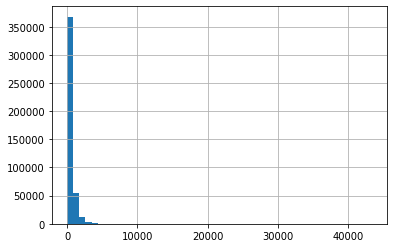

In [ ]:
#Количество символов в тексте комментария
df["comment"].str.len().hist(bins = 50)
#Из-за выбросов график неинформативен, количество символов в отдельных случаях достигает значений более 30000.

На графике распределения количества символов в есть ярко выраженные выбросы, которые сильно искажают общую картину. Некоторые посты содержат до 30000 и более символов, что значительно превышает среднее значение. Из-за этих выбросов график неинформативен, поскольку основная часть данных сгруппирована в узком диапазоне.

<Axes: >

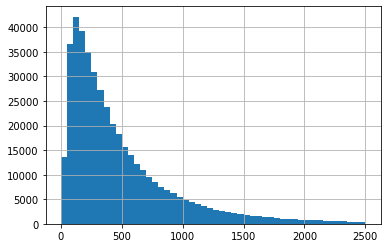

In [ ]:
#Количество символов в тексте комментария(диапазон от 0 до 2500)
df["comment"].str.len().hist(range=(0,2500), bins = 50)
#Длина примерно половины комментариев не превышает 500 символов, большей части - 1000 символов. Наиболее часто встречаются комментарии длины 150-250 символов.

Длина примерно половины комментариев не превышает 500 символов, большей части - 1000 символов. Наиболее часто встречаются комментарии длины 150-250 символов.

<Axes: >

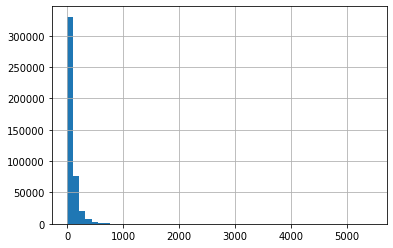

In [ ]:
#Количество слов в тексте комментария
df["comment"].str.split().map(lambda x: len(x)).hist(bins = 50)
#Из-за выбросов график неинформативен, количество слов в отдельных случаях достигает значений более 4000.

Из-за выбросов график неинформативен, количество слов в отдельных случаях достигает значений более 4000.

<Axes: >

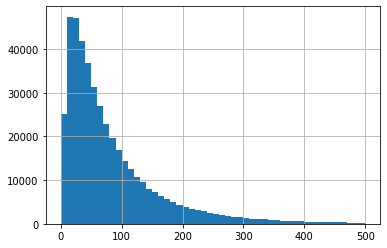

In [ ]:
#Количество слов в тексте комментария
df["comment"].str.split().map(lambda x: len(x)).hist(range=(0,500), bins = 50)
#Люди редко пишут комментарии длиннее 100-200 слов, график аналогичен предыдущему.

Люди редко пишут комментарии длиннее 100-200 слов, график аналогичен графику по количеству символов.

In [ ]:
#Посмотрим что из себя представляют очень длинные комментарии более 2000 слов
for comment in df["comment"]:
  if len(comment.split())> 2000:
    print("NEW_COMMENT__________________________________________________________________________________________________________________________________")
    print(comment)
#Это спам комментарии с большим количеством ссылок или большие тексты скопированные из различных источников 

NEW_COMMENT__________________________________________________________________________________________________________________________________
It's not true that killed stories can't be seen by anyone except the submitter.  They can be seen by everyone else who has showdead turned on.You can easily check whether a site is banned by submitting something from it and seeing if it gets killed immediately.  I.e. if it's visible on the new page to someone who's not logged in.  (You may have to wait a minute because the new page is cached.)  Here is the complete list:(gamenode.com tytka.blogspot.com fantasysportstrades.com mnhomerental.com downloadeverybodyhateschris.wordpress.com nickherbcpa.com cheepbaseballtickets.com infinitewraps.com freerotator.com copoff.org themmadigest.com mywirelessincome.com watchdollhouse.tv totalleathersolutions.com expofutures.com digital-scrapbook.net inlineseo.com orbitmerchantsolutions.com hostexcellencereview.org drama20show.com pain-killers.net topicster.com

Это спам комментарии с большим количеством ссылок или большие тексты скопированные из различных источников

<Axes: >

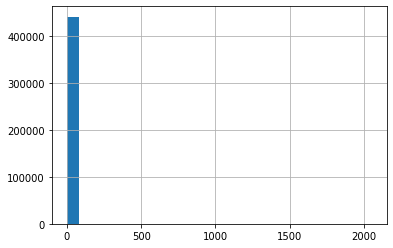

In [ ]:
#Средняя длина слов в комментарии
df['comment'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(bins = 25)
#Из-за выбросов график крайне неинформативен, длина слов в отдельных случаях достигает значений более 1500.

Из-за выбросов график крайне неинформативен, длина слов в отдельных случаях достигает значений более 1500.

Визуализация показывает, что на графике по длине слов встречаются выбросы, которые значительно выходят за пределы среднестатистических значений. Некоторые слова имеют длину более 1500 символов, что нехарактерно для текстового контента, доступного в интернете. Из-за таких выбросов график становится не очень информативным, и трудно выделить какие-то закономерности или тренды в данных.

<Axes: >

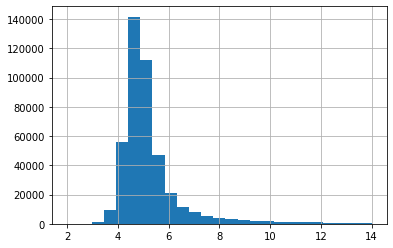

In [ ]:
#Средняя длина слов в комментарии (диапазон от 2 до 14)
df['comment'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(range=(2,14), bins = 25)
#Как и в случае с аналогичным графиком для текста поста, средняя длина слова примерно равна 5.5 символам, что соответствует стандартному распределению для английского языка. 

Как и в случае с аналогичным графиком для текста поста, средняя длина слова примерно равна 5.5 символам, что соответствует стандартному распределению для английского языка.


In [ ]:
#Поскольку вывод всех слов длиннее 45(максимальная длина слова в словарях английского язка), затруднителен ввиду большого количества ссылок, посмотрим какие слова больше 1000 символов повлияли на гарфик.
for comment in df["comment"]:
  for word in comment.split():
    if len(word) > 1000:
      print(word)
#Это крайне длинные ссылки, фрагменты кода и определённого рода "спам".

javascript:(function(){readStyle='style-newspaper';readSize='size-large';readMargin='margin-wide';_readability_script=document.createElement('SCRIPT');_readability_script.type='text/javascript';_readability_script.src='http://lab.arc90.com/experiments/readability/js/readability.js?x='+(Math.random());document.getElementsByTagName('head')[0].appendChild(_readability_script);_readability_css=document.createElement('LINK');_readability_css.rel='stylesheet';_readability_css.href='http://lab.arc90.com/experiments/readability/css/readability.css';_readability_css.type='text/css';_readability_css.media='screen';document.getElementsByTagName('head')[0].appendChild(_readability_css);_readability_print_css=document.createElement('LINK');_readability_print_css.rel='stylesheet';_readability_print_css.href='http://lab.arc90.com/experiments/readability/css/readability-print.css';_readability_print_css.media='print';_readability_print_css.type='text/css';document.getElementsByTagName('head')[0].appen

Это крайне длинные ссылки, фрагменты кода и определённого рода "спам".

Проведём очистку текста от стоп слов

In [11]:
# Импортируем библиотеки для очистки текста и определения темы
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Download the necessary resources for NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Tokenize the text and clean it by removing stopwords and special characters
def clean_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/CupIT/bigDataFrame.csv')
#df

In [12]:
pd.options.mode.chained_assignment = None

df["cleaned_post"] = ["None"]*len(df)
for i,post in enumerate(df["post"]):
    cleanPost = clean_text(post)
    df["cleaned_post"][i] = cleanPost

df["cleaned_comment"] = ["None"]*len(df)
for i,comment in enumerate(df["comment"]):
    cleanComment = clean_text(comment)
    df["cleaned_comment"][i] = cleanComment



Приведём аналогичные графики после очистки

<Axes: >

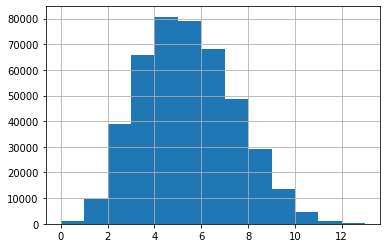

In [ ]:
#Количество слов в тексте поста
df["cleaned_post"].str.split().map(lambda x: len(x)).hist(range=(0,13), bins = 13)

Среднее количество слов в очищенном посте уменьшилось до 3-7

<Axes: >

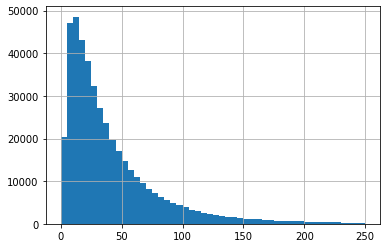

In [ ]:
#Количество слов в тексте комментария
df["cleaned_comment"].str.split().map(lambda x: len(x)).hist(range=(0,250), bins = 50)

Среднее количество слов в очищенном комментарии также уменьшилось 

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Axes: >

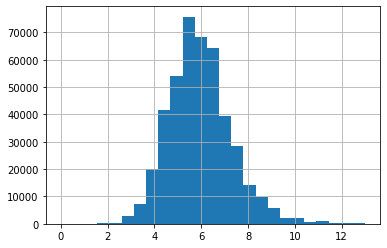

In [ ]:
#Средняя длина слов в посте
df['cleaned_post'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(range=(0,13), bins = 25)

Средняя длина слов в посте выросла до 6

<Axes: >

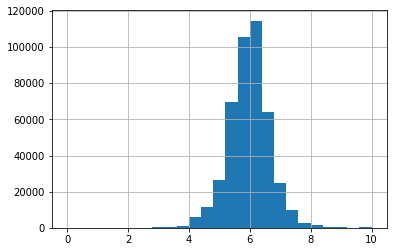

In [ ]:
#Средняя длина слов в комментарии
df['cleaned_comment'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(range=(0,10), bins = 25)

Средняя длина слов в комментарии также выросла до 6

Из полученных графиков можно сделать вывод, что очистка успешно удалила часто встречающиеся короткие стопслова, не несущие в себе ценной информации.

Оценим тональность и субъективность текстов

In [ ]:
from textblob import TextBlob
df["sentiment"] = [TextBlob(comment).sentiment for comment in df["comment"]]


In [ ]:
df["post_sentiment"] = [TextBlob(post).sentiment for post in df["post"]]


In [ ]:
TextBlob('''In the eternal words of the Geico Caveman.."What?"''').sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [ ]:
df["subjectivity"] = [sent[1] for sent in df["sentiment"]]
df["sentiment"] = [sent[0] for sent in df["sentiment"]]


<BarContainer object of 5 artists>

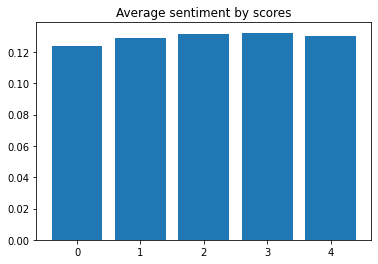

In [ ]:
#Средняя тональность по оценкам
avgSentiment = {i:0 for i in range(5)}

for score, sentiment in zip(df["score"],df["sentiment"]):
  avgSentiment[score] += sentiment
  

for key,value in avgSentiment.items():
  avgSentiment[key] = value/(len(df)/5)

plt.title('Average sentiment by scores')
plt.bar(avgSentiment.keys(), avgSentiment.values())


Как видно особой корреляции тональности и рейтинга комментария не проявляется, лучшие коментарии незначительно негативнее остальных

<BarContainer object of 5 artists>

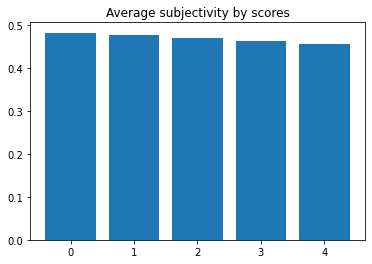

In [ ]:
#Средняя субъективность по оценкам
avgSubjectivity = {i:0 for i in range(5)}

for score, subjectivity in zip(df["score"],df["subjectivity"]):
  avgSubjectivity[score] += subjectivity
  

for key,value in avgSubjectivity.items():
  avgSubjectivity[key] = value/(len(df)/5)

plt.title('Average subjectivity by scores')
plt.bar(avgSubjectivity.keys(), avgSubjectivity.values())

Анализируя данные, можно сделать вывод, что субъективность комментариев не оказывает сильного влияния на их рейтинг. Однако, если провести более детальный анализ, можно заметить небольшую тенденцию - комментарии с более высоким рейтингом чуть более субъективны. Возможно, это связано с тем, что более эмоциональные комментарии могут вызывать более яркие эмоциональные отклики у читателей и, как следствие, более высокие оценки.

<BarContainer object of 5 artists>

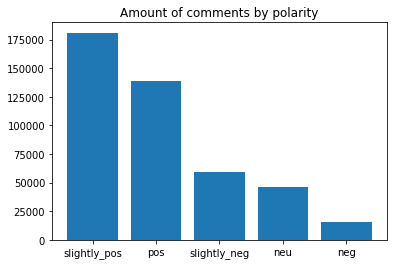

In [ ]:
#Распределение комментариев по полярности
def sentiment(x):
    if x<-0.2:
        return 'neg'
    elif x < 0:
        return 'slightly_neg'
    elif x==0:
        return 'neu'
    elif x < 0.2:
        return 'slightly_pos'
    else:
        return 'pos'

df['polarity']=df['sentiment'].map(lambda x: sentiment(x))
plt.title('Amount of comments by polarity')
plt.bar(df.polarity.value_counts().index, df.polarity.value_counts())

Как видно, большая часть комментариев имеет положительную или немного положительную окраску. Из этого можно сделать вывод, что пользователи ресурса, данные которого представлены в датасете предпочитают выражать позитивные мысли чаще негативных и нейтральных. Основываясь на этих данных, можно сделать предположение о том, что при разработке новых инструментов выражения мыслей для пользователей стоит в первую очередь ориентироваться на средства выражения положительных эмоций.

<BarContainer object of 5 artists>

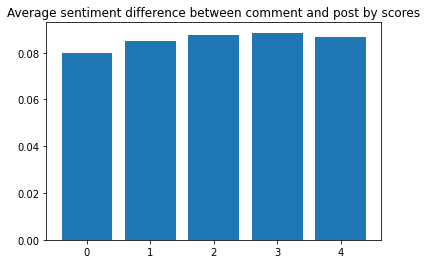

In [ ]:
#Среднее отклонение тональности комментария от тональноси поста по оценкам
avgSentimentDifference = {i:0 for i in range(5)}

for score, sentiment,post_sentiment in zip(df["score"],df["sentiment"],df["post_sentiment"]):
  avgSentimentDifference[score] += sentiment - post_sentiment[0]
  

for key,value in avgSentimentDifference.items():
  avgSentimentDifference[key] = value/(len(df)/5)

plt.title('Average sentiment difference between comment and post by scores')
plt.bar(avgSentimentDifference.keys(), avgSentimentDifference.values())

График отклонения тональности комментария от поста показывает, что в среднем комментарии немного позитивнее поста, к которому они написаны. В остальном график соостветствует обычному графику тональности комментариев.


Посмотрим на понятность текста в комменатриях

In [ ]:
#Установм специальные библиотеки
!pip install textstat
import textstat
from textstat import flesch_reading_ease

df["readability"] = df['comment'].apply(lambda x : flesch_reading_ease(x))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.8 MB/s eta 0:00:00


<Axes: >

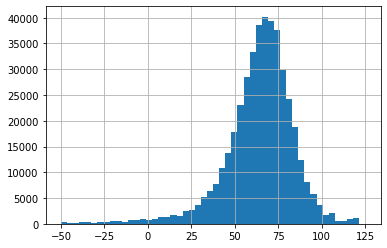

In [ ]:
#Количество комментариев по читаемости(понятности) (диапазон от -50 до 125)
df["readability"].hist(range=(-50,125), bins = 50)

Как видно, большая часть комментариев находится выше отметки 50, что означает, что они понятны болшинству англоговорящих людей. Уходящие в ноль и в минус значения соответствуют длинным скопированным сложным текстам и нечитаемому спаму.

<BarContainer object of 5 artists>

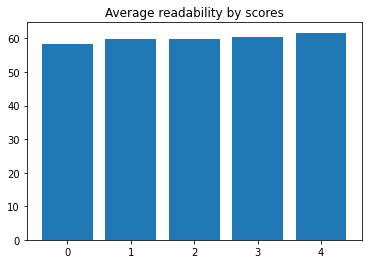

In [ ]:
#Средняя читаемость комментариев по оценкам
avgReadability = {i:0 for i in range(5)}

for score,readability in zip(df["score"],df["readability"]):
  avgReadability[score] += readability
  

for key,value in avgReadability.items():
  avgReadability[key] = value/(len(df)/5)

plt.title('Average readability by scores')
plt.bar(avgReadability.keys(), avgReadability.values())

Анализируя данные графика, можно сделать вывод, что зависимость между уровнем сложности комментариев и их рейтингом не прослеживается явно. Тем не менее, можно заметить, что лучшие комментарии в среднем незначительно сложнее к прочтению, чем остальные. Вероятно, это связано с тем, что авторы лучших комментариев стараются выразить свои мысли более точно и грамотно, используя более сложные конструкции и лексику. 

Сравним схожесть текстов поста и комментариев с помощью коэффициента Жаккара

In [ ]:
def jaccard_similarity(text1, text2):
    set1 = set(text1)
    set2 = set(text2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    
    return (len(intersection) / len(union)) if len(union)!=0 else 0

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

lem=WordNetLemmatizer()
df["lemmatized_comment"] = ["None"]*len(df)
for i,comment in enumerate(df["cleaned_comment"]):
  df["lemmatized_comment"][i] = [lem.lemmatize(word) for word in comment.split()]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df["lemmatized_post"] = ["None"]*len(df)
for i,post in enumerate(df["cleaned_post"]):
  df["lemmatized_post"][i] = [lem.lemmatize(word) for word in post.split()]

In [ ]:
df["similarity"] = [jaccard_similarity(comment,post) for comment, post in zip(df["lemmatized_comment"],df["lemmatized_post"])]

<BarContainer object of 5 artists>

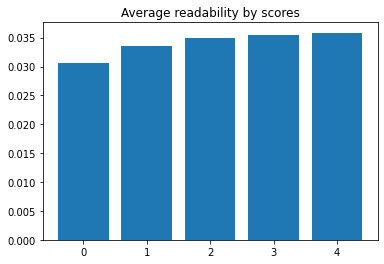

In [ ]:
#Средняя схожесть комментариев с постом по оценкам
avgSimilarity = {i:0 for i in range(5)}

for score,similarity in zip(df["score"],df["similarity"]):
  avgSimilarity[score] += similarity
  

for key,value in avgSimilarity.items():
  avgSimilarity[key] = value/(len(df)/5)

plt.title('Average readability by scores')
plt.bar(avgSimilarity.keys(), avgSimilarity.values())

По графику видно, что коэффициент Жаккара схожести комментария с текстом поста уменьшается с увеличением рейтинга комментария. Также это логично вытекает из ранее сделанного вывода, о том, что более популярные комментарии имеют большую дину чем обычные. Однако, разница схожести не такая значительная, как разница длин комментариев, что позволяет предположить, что пересечение множеств слов текста и лучшего комментария больше, чем аналогичная величина для остальных комментариев. Для подтверждения или опровержения гипотезы требуется дальнейшее исследование.

Теперь проверим зависимость грамотности текста комментария от его популярности

In [9]:
#Простая библиотека для проверки правописания
!pip install pyspellchecker
from spellchecker import SpellChecker

spell = SpellChecker()

# find those words that may be misspelled
def mistakes(text):
  return len(spell.unknown(text))



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


0

In [14]:
df["mistakes"] = [mistakes(comment.split()) for comment in df["cleaned_comment"]]
df

,post,comment,score,cleaned_post,cleaned_comment,mistakes
0,How many summer Y Combinator fundees decided n...,Going back to school is not identical with giv...,0,many summer combinator fundees decided continu...,going back school identical giving founders go...,0
1,How many summer Y Combinator fundees decided n...,There will invariably be those who don't see t...,1,many summer combinator fundees decided continu...,invariably see success set fall back original ...,0
2,How many summer Y Combinator fundees decided n...,For me school is a way to be connected to what...,2,many summer combinator fundees decided continu...,school way connected going real world entered ...,0
3,How many summer Y Combinator fundees decided n...,I guess it really depends on how hungry you ar...,3,many summer combinator fundees decided continu...,guess really depends hungry much believe produ...,1
4,How many summer Y Combinator fundees decided n...,I know pollground decided to go back to school...,4,many summer combinator fundees decided continu...,know pollground decided go back school getting...,2
...,...,...,...,...,...,...
440530,Pay your rent with a Credit or Debit card. No ...,Most major banks offer a service called &#x27;...,0,pay rent credit debit card landlord signup req...,major banks offer service called bill pay free...,2
440531,Pay your rent with a Credit or Debit card. No ...,"It costs 3.25%, or $74.25 for the example of $...",1,pay rent credit debit card landlord signup req...,costs example looking rack quot reward points ...,1
440532,Pay your rent with a Credit or Debit card. No ...,As many other comments have pointed out almost...,2,pay rent credit debit card landlord signup req...,many comments pointed almost everyone debit ca...,1
440533,Pay your rent with a Credit or Debit card. No ...,My apartment building uses Yapstone&#x27;s Ren...,3,pay rent credit debit card landlord signup req...,apartment building uses yapstone charges flat ...,2


In [15]:
#Сохраним таблицу с найденными значениями
df.to_csv("/content/drive/MyDrive/bigDataFrame.csv")

<BarContainer object of 5 artists>

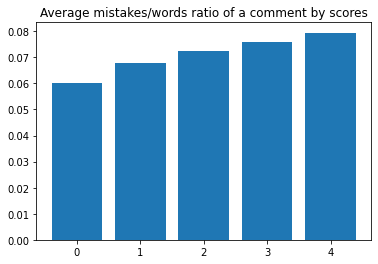

In [19]:
#Средняя доля ошибок правописания в комментариях по оценкам
avgMistakes = {i:0 for i in range(5)}

for score,comment, mistakes in zip(df["score"],df["cleaned_comment"],df["mistakes"]):
  avgMistakes[score] += (mistakes/len(comment.split())  if len(comment.split())!=0 else 0)
  

for key,value in avgMistakes.items():
  avgMistakes[key] = value/(len(df)/5)

plt.title('Average mistakes/words ratio of a comment by scores')
plt.bar(avgMistakes.keys(), avgMistakes.values())

Как видно из графика, популярность комментария явно зависит от его грамотности. Из этого можно сделать вывод что грамотность текста повышает его привлекательность для пользователей (или в обратную сторону - неграмотность текста снижает его привлекаельность).

Проведённый анализ данных позволил сделать выводы, которые можно использовать для улучшения работы с комментариями в рамках ресурса, откуда была взята предоставленная выборка.